<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/p_delta/cant_col_p_delta.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
</div>

<img src="../../assets/img/structure/opensees/coupon.jpg" alt="Steel Coupon" width='auto'>

# OpenSees Uniaxial Steel Materials

The objective of this notebook is to visually explore the uniaxial steel materials in OpenSees. It is not intended to provide a deep understanding of nonlinear behavior of steel under cyclic loading. The reader is encourage to refer to advanced mechanics of materials and plasticity refenreces for furthre study (some are listed under [References](#references)). Below is the list uniaxial steel material in OpenSees:

* `Steel01`
* `Steel02`
* `Steel4`
* `ReinforcingSteel`
* `Dodd_Restrepo`
* `RambergOsgoodSteel`
* `SteelMPF`
* `Steel01Thermal`

Let's begin by comparing the first two. To do so, I will create an OpenSees model to generate stress-strain data.

## Steel01 vs. Steel02

The `Steel01` uniaxial steel is bilinear models with _kinematic hardening_ and optional _isotropic hardening_. In the _isotropic hardening_ the yield surface expands uniformly in all directions resulting in increase or decrease of the yield stress in all directions as plastic deformation proceeds. On the other hand, in the _kinematic hardening_ the yield surface translate (shift) is stress space with no change in size or shape, representing the _Bauschinger effect_ and enabling modeling of the cyclic behavior of metals. The `Steel02` is based on Giuffre-Menegotto-Pinto model with isotropic hardening.


<img src="../../assets/img/structure/opensees/kinematic_isotropic.jpg" alt="Kinematic and Isotropic Hardening" width='auto'>




In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import sys

In [6]:
import openseespy.opensees as ops


# Reset model
ops.wipe()
ops.model('basic', '-ndm', 1, '-ndf', 1)


# Materials
nMat = 2
matTags = list(range(1, nMat + 1))
matNames = ['Steel01', 'Steel02']

Fy, E0, b = 50, 29000, 0.005
ops.uniaxialMaterial('Steel01', matTags[0], Fy, E0, b)

R0, cR1, cR2 = 15, 0.925, 0.15
ops.uniaxialMaterial('Steel02', matTags[1], Fy, E0, b, R0, cR1, cR2)


# Geometry
A, L = 1.0, 1.0  # Area and length
fixed_nodeTags = list(range(1, nMat + 1)) 
free_nodeTags = []
eleTags =  list(range(1, nMat + 1))
for i in range(nMat):
    free_nodeTags.append(fixed_nodeTags[i] + 100)
    ops.node(fixed_nodeTags[i], 0.0)
    ops.node(free_nodeTags[i], L)
    ops.fix(fixed_nodeTags[i], 1)
    if i != 0:
        ops.equalDOF(free_nodeTags[0], free_nodeTags[i], 1)
    ops.element('Truss', eleTags[i], fixed_nodeTags[i], free_nodeTags[i], A, matTags[i])  




# Cyclic strain history (OpenSees doc example)
# https://opensees.berkeley.edu/OpenSees/manuals/comparisonManual/2770.htm
run1 = [0.20]
run2 = [-0.20]
run3 = [0.02, -0.02, 0.0]
run4 = [-0.02, 0.02, 0.0]
run5 = [0.20, -0.20, 0.0]
run6 = [-0.20, 0.20, 0.0]
run7 = [0.0005, 0, 0.001, 0, 0.005, 0, 0.05, 0, 0.10, 0, 0.15, 0, 0.20, 0.0]
run8 = [-0.0005, 0, -0.001, 0, -0.005, 0, -0.05, 0, -0.10, 0, -0.15, 0, -0.20, 0.0]
run9 = [0.001, -0.001, 0.005, -0.005, 0.01, -0.01, 0.02, -0.02, 0.0]
run10 = [0.001, -0.001, 0.005, -0.005, 0.01, -0.01, 0.02, -0.02, 0.05, -0.05, 0.10, -0.10, 0.15, -0.15, 0.20, -0.20, 0.0]
runs = [run1, run2, run3, run4, run5, run6, run7, run8, run9, run10]


# Dummy load pattern
timeSeriesTag = 1
ops.timeSeries('Linear', timeSeriesTag)
patternTag = 1
ops.pattern('Plain', patternTag, timeSeriesTag)
loading_nodeTag = free_nodeTags[0]
load_value = 1e-8
ops.load(loading_nodeTag, load_value)  # Dummy load to satisfy pattern requirements


# Analysis settings
ops.constraints('Plain')
ops.numberer('Plain')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1e-8, 10)
ops.algorithm('Newton')        
   
nIncr = 1000
dof = 1
strains = {}
stresses = {}


for i, run in enumerate(runs): # Loop over each strain history
    strain_peaks = run
    disp_peaks = [L * eps for eps in strain_peaks] 
    strains[i] = [0]  
    stresses[i] = {}
    for eleTag in eleTags:
        stresses[i][eleTag] = [0]   
    current_disp = 0.0   
    ops.reset() # Earase previous analysis results
            
    for target_disp in disp_peaks: # Loop over displacement peaks in each history
        delta_disp = (target_disp - current_disp) / nIncr

        for _ in range(nIncr): # Incremental analysis, run the analysis for each displacement increment
            ops.integrator('DisplacementControl', free_nodeTags[0], dof, delta_disp)
            ops.analysis('Static')
            ok = ops.analyze(1)
            
            if ok != 0:
                print(f"Analysis failed during increment to {target_disp}")
                break
            current_disp += delta_disp
            strains[i].append(current_disp / L)
            for eleTag in eleTags:
                stress = ops.eleResponse(eleTag, 'axialForce')[0] / A
                stresses[i][eleTag].append(stress)



In [ ]:
nRuns = len(runs)
colors = ['black', '#EA7300']
fig, axes = plt.subplots(nRuns, 2, figsize=(8, 30), width_ratios=[1,1])

for i in range(nRuns):
    strain = strains[i]
    max_strain = max(abs(np.array(strain)))
    
    axis = axes[i, 0]
    max_stress = 0
    for j, eleTag in enumerate(eleTags):
        stress = stresses[i][eleTag]
        norm_stress = np.array(stress) / Fy  # Normalize stress by yield strength    
        axis.plot(strain, norm_stress, color=colors[j], linewidth=2, label=matNames[j])
        max_stress = max(max_stress, np.max(np.abs(norm_stress)))
    axis.set_ylim(max_stress * np.array([-1.1, 1.1]))
    axis.set_xlim(max_strain * np.array([-1.1, 1.1]))
    axis.set_xlabel('Strain', fontsize=10)
    axis.set_ylabel('Stress / Fy', fontsize=10)
    axis.set_title(f'Normalized Stress-Strain Curve (Run {i+1})', fontsize=10, pad=20)
    axis.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(eleTags), frameon=False, fontsize=8)
    axis.tick_params(axis='both', labelsize=8)
    axis.grid(True, linestyle=':')
        
    step = range(nIncr * len(runs[i])+1)
    axis = axes[i, 1]
    axis.plot(step, strain, color='red', linewidth=1, label=f'Run {i+1}')
    axis.set_ylim(max_strain * np.array([-1.1, 1.1]))
    axis.set_xlabel('Step', fontsize=10)
    axis.set_ylabel('Strain', fontsize=10)
    axis.set_title(f'Strain History (Run {i+1})', fontsize=10, pad=20)
    axis.tick_params(axis='both', labelsize=8)
    axis.grid(True, linestyle=':')

plt.tight_layout()
plt.show()

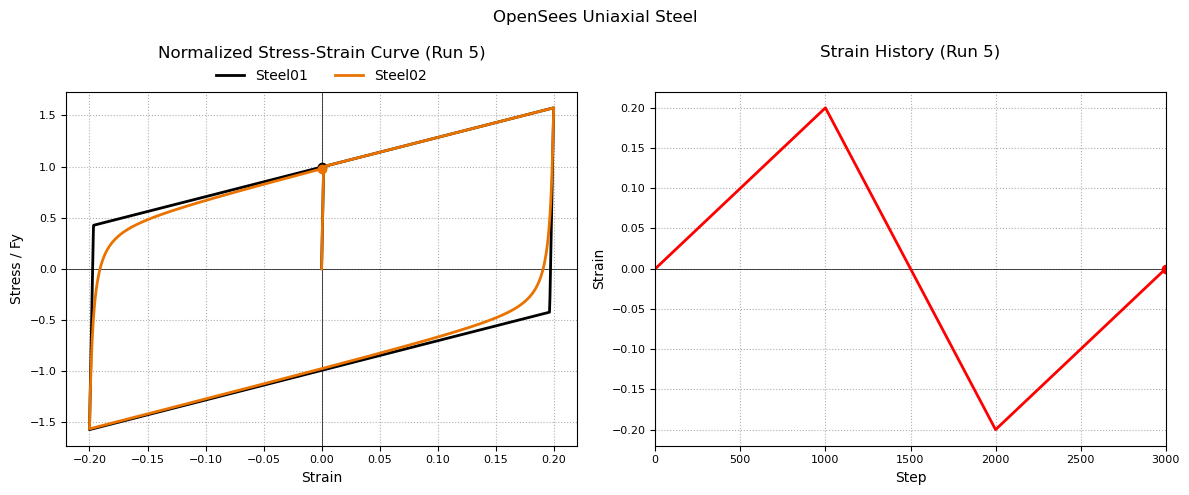

In [26]:
from IPython.display import display, clear_output
import time


# Select which run to plot (between 0 and nRuns-1)
RUN_NUM = 4  


# Create a single frame plot
def create_frame(frame, save=False):
    """Create stress-strain and strain history plots for a specific frame"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), width_ratios=[1, 1])
    fig.subplots_adjust(top=0.85)
    colors = ['black', '#EA7300']
    
    strain = np.array(strains[RUN_NUM])
    max_strain = np.max(np.abs(strain))
    max_norm_stress = 0
    for eleTag in eleTags:
        stress = np.array(stresses[RUN_NUM][eleTag])
        norm_stress = stress / Fy
        max_norm_stress = max(max_norm_stress, np.max(np.abs(norm_stress)))

    axis_left = axes[0]
    axis_left.axhline(0, color='black', linewidth=0.5, linestyle='-')
    axis_left.axvline(0, color='black', linewidth=0.5, linestyle='-')
    for j, eleTag in enumerate(eleTags):
        stress = np.array(stresses[RUN_NUM][eleTag])
        norm_stress = stress / Fy
        axis_left.plot(strain[:frame+1], norm_stress[:frame+1], color=colors[j], linewidth=2, label=matNames[j])
        axis_left.plot(strain[frame], norm_stress[frame], 'o', color=colors[j])
    axis_left.set_ylim(max_norm_stress * np.array([-1.1, 1.1]))
    axis_left.set_xlim(max_strain * np.array([-1.1, 1.1]))
    axis_left.set_xlabel('Strain')
    axis_left.set_ylabel('Stress / Fy')
    axis_left.set_title(f'Normalized Stress-Strain Curve (Run {RUN_NUM+1})', pad=25)
    axis_left.legend(loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=len(eleTags), frameon=False, fontsize=10)
    axis_left.tick_params(axis='both', labelsize=8)
    axis_left.grid(True, linestyle=':')
    
    axis_right = axes[1]
    axis_right.axhline(0, color='black', linewidth=0.5, linestyle='-')
    axis_right.plot(np.arange(frame+1), strain[:frame+1], 'r-', linewidth=2)
    axis_right.plot(frame, strain[frame], 'ro')
    axis_right.set_ylim(max_strain * np.array([-1.1, 1.1]))
    axis_right.set_xlim([0, len(strain)])
    axis_right.set_xlabel('Step')
    axis_right.set_ylabel('Strain')
    axis_right.set_title(f'Strain History (Run {RUN_NUM+1})', pad=25)
    axis_right.tick_params(axis='both', labelsize=8)
    axis_right.grid(True, linestyle=':')
    
    plt.suptitle("OpenSees Uniaxial Steel")
    plt.tight_layout()
    
    if save:
        plt.savefig(f"frame_{frame:04d}.png", dpi=80)
        plt.close()
    else:
        return fig


def animate_manually(frames_to_show=None, delay=0.2):
    """Create a manual animation using IPython's clear_output and display"""
    strain = np.array(strains[RUN_NUM])
    
    if frames_to_show is None:
        # Calculate frames to show - skip to keep ~100 frames total
        frame_skip = max(1, len(strain) // 100)
        frames_to_show = range(0, len(strain), frame_skip)
    
    for frame in frames_to_show:
        clear_output(wait=True)
        fig = create_frame(frame)
        display(fig)
        plt.close(fig)
        time.sleep(delay)


def save_all_frames():
    """Save all frames as image files"""
    strain = np.array(strains[RUN_NUM])
    frame_skip = max(1, len(strain) // 100)
    frames_to_save = range(0, len(strain), frame_skip)
    
    for frame in frames_to_save:
        create_frame(frame, save=True)
        
    print(f"Saved {len(frames_to_save)} frames as PNG files.")


animate_manually()  # For interactive animation in notebook
# save_all_frames()   # To save frames as images

## References

1. Ottosen, N. S., Ristinmaa, M., The Machanics of Constitutive Modeling, Elsevier.
2. Boresi, A. P., Schmidt R.J., Advance Machanics of Materials, John Wiley & Sons, Inc.
